# Classification of Subreddits

In [33]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [20]:
# read in cleaned data
reddits = pd.read_csv('data/clean_reddits.csv')

In [3]:
reddits.head(2)

,author,created_utc,permalink,subreddit,text
0,dwaxe,1601660299,/r/TheOnion/comments/j3z3ds/real_estate_expert...,TheOnion,Real Estate Experts Confirm Having George Cloo...
1,kc9283,1601604158,/r/TheOnion/comments/j3m23g/subway_bread_isnt_...,TheOnion,"Subway bread isn't bread, Irish court says"


In [64]:
reddits.tail(2)

,author,created_utc,permalink,subreddit,text
29976,tamilidhal,1601267115,/r/news/comments/j15hsk/படடததரவகளல_பஙகறற_வலவயப...,news,போட்டித்தேர்வுகளில் பங்கேற்று வேலைவாய்ப்பு பெற...
29977,tamilidhal,1601267114,/r/news/comments/j15hs8/கரககல_அரச_மரததவமனயல_சம...,news,காரைக்கால் அரசு மருத்துவமனையில் சிமென்ட் காரை ...


In [65]:
reddits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29978 entries, 0 to 29977
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       29978 non-null  object
 1   created_utc  29978 non-null  int64 
 2   permalink    29978 non-null  object
 3   subreddit    29978 non-null  object
 4   text         29978 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [55]:
reddits.shape

(29978, 5)

In [21]:
# set X and y
X = reddits['text']

# binarize the target.
y = np.where(reddits['subreddit'] == 'TheOnion', 1, 0)

In [22]:
# train test split (no need to stratify, sample number are essentially the same for both subreddits)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 777)

### Calculating the baseline

In [6]:
y_test.sum() / len(y_test)

0.49966644429619744

##### As expected, the baseline would be 50% if guessed The Onion. It's essentially as good as a coin toss.

In [48]:
# instatiate CounterVectorizer
cvect = CountVectorizer(stop_words='english')

In [49]:
X_train_cvect = cvect.fit_transform(X_train, y_train)
X_test_cvect = cvect.transform(X_test)

#### A tiny bit of EDA

In [50]:
# convert X_train to df
X_train_df = pd.DataFrame(X_train_cvect.toarray(),
                          columns=cvect.get_feature_names())

# empty dictionary
top_words = {}

# loop through columns
for i in X_train_df.columns:
    # save sum of each column in dictionary
    top_words[i] = X_train_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

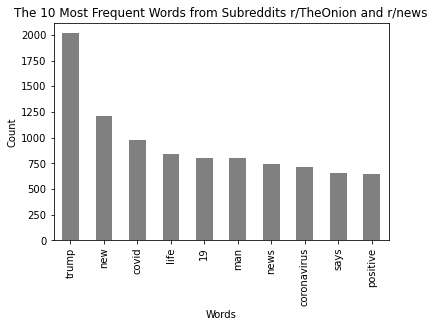

In [52]:
# convert most frequent words to dataframe
most_freq_df = pd.DataFrame(most_freq)

# visualize top 10 words
most_freq_df.nlargest(10, 1).plot(kind = 'bar', legend=None, color='grey')
plt.xticks([i for i in range(10)], [col for col in most_freq_df.nlargest(10, 1)[0]])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('The 10 Most Frequent Words from Subreddits r/TheOnion and r/news')
plt.savefig('figures/countvectorizer_10_most_frequent_words', bbox_inches='tight');

All those words look relevant, so I don't there is any need to add more stop words. However, I may benefit from stemming or keeping some words together like covid and 19. For right now, I will continue with this set.

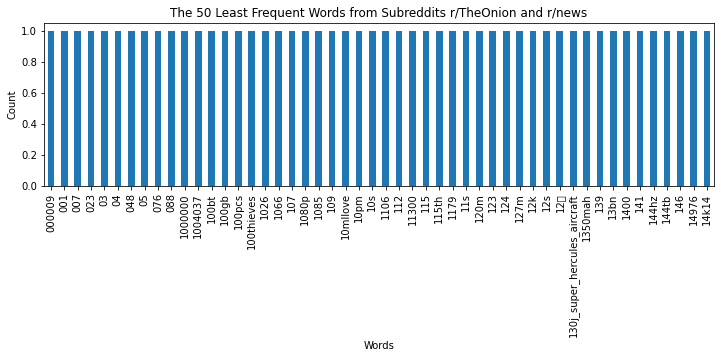

In [121]:
most_freq_df.nsmallest(50, 1).plot(kind = 'bar', legend=None, figsize=(12, 3))
plt.xticks([i for i in range(50)], [col for col in most_freq_df.nsmallest(50, 1)[0]])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('The 50 Least Frequent Words from Subreddits r/TheOnion and r/news');

Most of these look like random number. I will set the minimum occurance to 2 when fine tuning.

In [84]:
# how many words total after countervectorizer?
X_train_cvect.shape

(22483, 31904)

### Classification using CounterVectorizer and LogisticRegression

In [25]:
# scale vectorized X
ss = StandardScaler(with_mean=False)
X_train_cvect_ss = ss.fit_transform(X_train_cvect, y_train)
X_test_cvect_ss = ss.transform(X_test_cvect)

In [26]:
# instatiate and fit 
logr = LogisticRegression(max_iter=10000)
logr.fit(X_train_cvect_ss, y_train)

LogisticRegression(max_iter=10000)

In [27]:
# score
print('train score:', logr.score(X_train_cvect_ss, y_train))
print('test_score:', logr.score(X_test_cvect_ss, y_test))

train score: 0.9997776097495886
test_score: 0.8461641094062708


In [37]:
# add scores to file
scores_df = pd.read_csv('data/model_scores.csv')
train_score = logr.score(X_train_cvect_ss, y_train)
test_score = logr.score(X_test_cvect_ss, y_test)
score_df = pd.DataFrame({'model': 'logistic_regression', 'train_accuracy': train_score, 'test_accuracy': test_score},  index=[0])
score_df = pd.concat([scores_df, score_df], ignore_index=True)
score_df.to_csv('data/model_scores.csv', index=False)

In [195]:
# cross validate
cross_val_score(logr, X_train_cvect_ss, y_train, cv=3)

array([0.83322215, 0.83133173, 0.83106485])

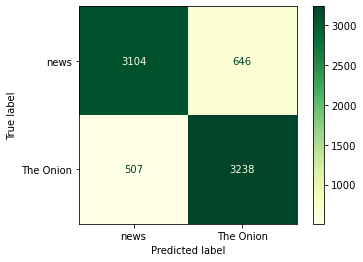

In [196]:
plot_confusion_matrix(logr, X_test_cvect_ss, y_test, display_labels=['news', 'The Onion'], cmap='YlGn');

### Classification using TfidfVectorizer and LogisticRegression

In [23]:
# Instantiate the TfidfVectorizer
tvec = TfidfVectorizer(stop_words='english')

In [75]:
X_train_tvec = tvec.fit_transform(X_train, y_train)
X_test_tvec = tvec.transform(X_test)

In [197]:
# scale
X_train_tvec_ss = ss.fit_transform(X_train_tvec, y_train)
X_test_tvec_ss = ss.transform(X_test_tvec)

In [199]:
# fit to logistic model
logr2 = LogisticRegression(max_iter=10000)
logr2.fit(X_train_tvec_ss, y_train)

LogisticRegression(max_iter=10000)

In [200]:
# score
print('train score:', logr2.score(X_train_tvec_ss, y_train))
print('test_score:', logr2.score(X_test_tvec_ss, y_test))

train score: 0.9997776097495886
test_score: 0.8588392261507671


In [201]:
# cross validate
cross_val_score(logr2, X_train_tvec_ss, y_train, cv=3)

array([0.84656438, 0.84294102, 0.84214038])

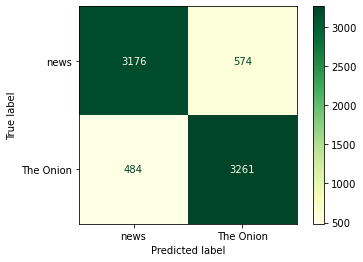

In [202]:
plot_confusion_matrix(logr2, X_test_tvec_ss, y_test, display_labels=['news', 'The Onion'], cmap='YlGn');

TfidVectorizer or CounterVectorizer don't seem to make a difference on the model.

### Classification using WordNetLemmatizer, CountVectorizer, and LogisticRegression

In [44]:
# make a function for lemmatizer
def split_lemm(text):
    text = text.lower()
    lemm = WordNetLemmatizer()
    return ' '.join([lemm.lemmatize(word) for word in text.split()])

# instatiate countvectorizer with lemmatizer
lem_cvect = CountVectorizer(preprocessor=split_lemm, stop_words='english')

In [45]:
X_train_lem_cvect = lem_cvect.fit_transform(X_train, y_train)
X_test_lem_cvect = lem_cvect.transform(X_test)

/Users/emikobea/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [46]:
# convert X_train to df
X_train_df_lem = pd.DataFrame(X_train_lem_cvect.toarray(),
                          columns=lem_cvect.get_feature_names())

# empty dictionary
top_words2 = {}

# loop through columns
for i in X_train_df_lem.columns:
    # save sum of each column in dictionary
    top_words2[i] = X_train_df_lem[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq2 = pd.DataFrame(sorted(top_words2.items(), key = lambda x: x[1], reverse = True))

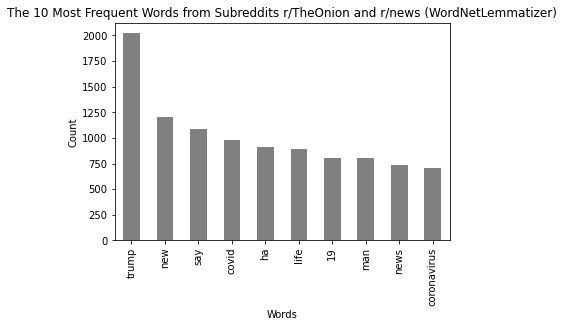

In [47]:
# convert most frequent words to dataframe
most_freq_df_lem = pd.DataFrame(most_freq2)

# visualize top 10 words
most_freq_df_lem.nlargest(10, 1).plot(kind = 'bar', legend=None, color='grey')
plt.xticks([i for i in range(10)], [col for col in most_freq_df_lem.nlargest(10, 1)[0]])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('The 10 Most Frequent Words from Subreddits r/TheOnion and r/news (WordNetLemmatizer)')
plt.savefig('figures/lem_10_most_frequent_words', bbox_inches='tight');

It changed the ranking a little compared to plain `CountVectorizer` but not a lot.

In [203]:
# scale
X_train_lem_cvect_ss = ss.fit_transform(X_train_lem_cvect, y_train)
X_test_lem_cvect_ss = ss.transform(X_test_lem_cvect)

In [204]:
# fit to logistic model
logr3 = LogisticRegression(max_iter=10000)
logr3.fit(X_train_lem_cvect_ss, y_train)

LogisticRegression(max_iter=10000)

In [205]:
# score
print('train score:', logr3.score(X_train_lem_cvect_ss, y_train))
print('test_score:', logr3.score(X_test_lem_cvect_ss, y_test))

train score: 0.9997776097495886
test_score: 0.8360240160106738


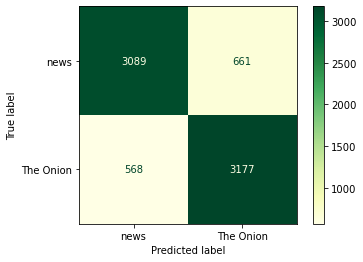

In [206]:
plot_confusion_matrix(logr3, X_test_lem_cvect_ss, y_test, display_labels=['news', 'The Onion'], cmap='YlGn');

### Classification using PortStemmer, CountVectorizer, and LogisticRegression

In [40]:
def split_stem(text):
    text = text.lower()
    stem = PorterStemmer()
    return ' '.join([stem.stem(word) for word in text.split()])

# instatiate countvectorizer with lemmatizer
stem_cvect = CountVectorizer(preprocessor=split_stem, stop_words='english')

In [41]:
X_train_stem_cvect = stem_cvect.fit_transform(X_train, y_train)
X_test_stem_cvect = stem_cvect.transform(X_test)

/Users/emikobea/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_wor

In [42]:
# convert X_train to df
X_train_df_stem = pd.DataFrame(X_train_stem_cvect.toarray(),
                          columns=stem_cvect.get_feature_names())

# empty dictionary
top_words3 = {}

# loop through columns
for i in X_train_df_stem.columns:
    # save sum of each column in dictionary
    top_words3[i] = X_train_df_stem[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq3 = pd.DataFrame(sorted(top_words3.items(), key = lambda x: x[1], reverse = True))

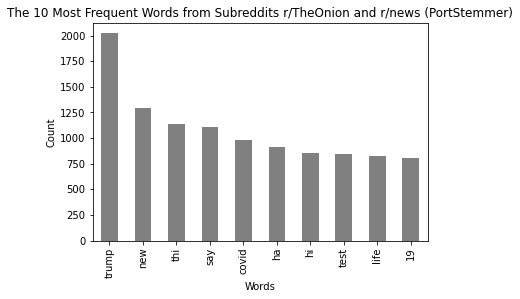

In [43]:
# convert most frequent words to dataframe
most_freq_df_stem = pd.DataFrame(most_freq3)

# visualize top 10 words
most_freq_df_stem.nlargest(10, 1).plot(kind = 'bar', legend=None, color='grey')
plt.xticks([i for i in range(10)], [col for col in most_freq_df_stem.nlargest(10, 1)[0]])
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('The 10 Most Frequent Words from Subreddits r/TheOnion and r/news (PortStemmer)')
plt.savefig('figures/stem_10_most_frequent_words', bbox_inches='tight');

In [207]:
# scale
X_train_stem_cvect_ss = ss.fit_transform(X_train_stem_cvect, y_train)
X_test_stem_cvect_ss = ss.transform(X_test_stem_cvect)

In [208]:
# fit to logistic model
logr4 = LogisticRegression(max_iter=10000)
logr4.fit(X_train_stem_cvect_ss, y_train)

LogisticRegression(max_iter=10000)

In [209]:
# score
print('train score:', logr4.score(X_train_stem_cvect_ss, y_train))
print('test_score:', logr4.score(X_test_stem_cvect_ss, y_test))

train score: 0.9997776097495886
test_score: 0.8345563709139426


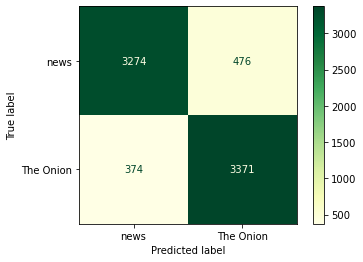

In [153]:
plot_confusion_matrix(logr4, X_test_stem_cvect, y_test, display_labels=['news', 'The Onion'], cmap='YlGn');

Stemming is not really making a difference.

### Optimazing LogisticRegression with CountVectorizer

In [6]:
# use pipeline and gridsearch to try to improve the accuracy score
cvect = CountVectorizer(stop_words='english')
logr5 = LogisticRegression(max_iter=10000)
sscale = StandardScaler(with_mean=False)

# make a pipeline
pipe = make_pipeline(cvect, sscale, logr5)


params = {
    'countvectorizer__max_features': [2000, 3000, 4000, 5000],
    'countvectorizer__min_df': [2 ,3],
    'countvectorizer__max_df': [0.9, 0.95],
    'countvectorizer__ngram_range': [(1,1), (1, 2)],
    'logisticregression__C': [0.01, 0.1, 1., 10.]
              }

grid = GridSearchCV(pipe, params, n_jobs = -1)

In [213]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.9, 0.95],
                         'countvectorizer__max_features': [2000, 3000, 4000,
                                                           5000],
                         'countvectorizer__min_df': [2, 3],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'logisticregression__C': [0.01, 0.1, 1.0, 10.0]})

In [214]:
grid.best_params_

{'countvectorizer__max_df': 0.9,
 'countvectorizer__max_features': 5000,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 1),
 'logisticregression__C': 0.01}

In [215]:
# score
print('train score:', grid.score(X_train, y_train))
print('test_score:', grid.score(X_test, y_test))

train score: 0.9580571987724058
test_score: 0.8693795863909273


In [217]:
# try again for more fine tuning, also including lemmatization

params2 = {
    'countvectorizer__max_features': [15000, 20000],
    'countvectorizer__min_df': [2],
    'countvectorizer__max_df': [0.4, 0.6, 0.8],
    'countvectorizer__ngram_range': [(1,1), (1, 2)],
    'countvectorizer__preprocessor': [None, split_lemm],
    'logisticregression__C': [0.001, 0.01, 0.1]
              }

grid2 = GridSearchCV(pipe, params2, n_jobs = -1)

grid2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.4, 0.6, 0.8],
                         'countvectorizer__max_features': [15000, 20000],
                         'countvectorizer__min_df': [2],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'countvectorizer__preprocessor': [None,
                                                           <function split_lemm at 0x7fb77b599290>],
                         'logisticregression__C': [0.001, 0.01, 0.1]})

In [218]:
grid2.best_params_

{'countvectorizer__max_df': 0.4,
 'countvectorizer__max_features': 20000,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__preprocessor': None,
 'logisticregression__C': 0.001}

In [219]:
# score
print('train score:', grid2.score(X_train, y_train))
print('test_score:', grid2.score(X_test, y_test))

train score: 0.9879019703776186
test_score: 0.8979319546364243


In [9]:
# one more time fine tuning with stemming
params3 = {
    'countvectorizer__max_features': [15000, 20000],
    'countvectorizer__min_df': [2],
    'countvectorizer__max_df': [0.2, 0.4, 0.6],
    'countvectorizer__ngram_range': [(1,1), (1, 2)],
    'countvectorizer__preprocessor': [None, split_stem],
    'logisticregression__C': [0.001, 0.01, 0.1]
              }

grid3 = GridSearchCV(pipe, params3, n_jobs = -1)

grid3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.2, 0.4, 0.6],
                         'countvectorizer__max_features': [15000, 20000],
                         'countvectorizer__min_df': [2],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'countvectorizer__preprocessor': [None,
                                                           <function split_stem at 0x7fd5f8c158c0>],
                         'logisticregression__C': [0.001, 0.01, 0.1]})

In [10]:
grid3.best_params_

{'countvectorizer__max_df': 0.2,
 'countvectorizer__max_features': 20000,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__preprocessor': None,
 'logisticregression__C': 0.001}

In [11]:
# score
print('train score:', grid3.score(X_train, y_train))
print('test_score:', grid3.score(X_test, y_test))

train score: 0.9879019703776186
test_score: 0.8979319546364243


Stemming nor lemmatizing is making a difference

In [223]:
# one more time fine tuning
params4 = {
    'countvectorizer__max_features': [20000, 25000],
    'countvectorizer__min_df': [2],
    'countvectorizer__max_df': [0.1, 0.2],
    'countvectorizer__ngram_range': [(1, 2)],
    'logisticregression__C': [0.0001, 0.05, 0.001]
              }

grid4 = GridSearchCV(pipe, params4, n_jobs = -1)

grid4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.1, 0.2],
                         'countvectorizer__max_features': [20000, 25000],
                         'countvectorizer__min_df': [2],
                         'countvectorizer__ngram_range': [(1, 2)],
                         'logisticregression__C': [0.0001, 0.05, 0.001]})

In [224]:
grid4.best_params_

{'countvectorizer__max_df': 0.1,
 'countvectorizer__max_features': 25000,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 2),
 'logisticregression__C': 0.0001}

In [225]:
# score
print('train score:', grid4.score(X_train, y_train))
print('test_score:', grid4.score(X_test, y_test))

train score: 0.9660187697371347
test_score: 0.894863242161441


It's no really improving much anymore, so I will use `grid3` for getting details.

### Analysis of the best model

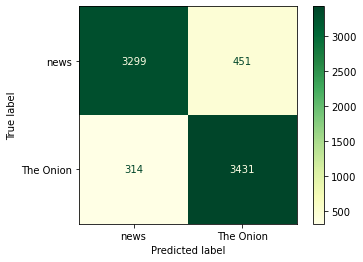

In [226]:
# confusion matrix
fig = plot_confusion_matrix(grid3, X_test, y_test, display_labels=['news', 'The Onion'], cmap='YlGn')
fig;

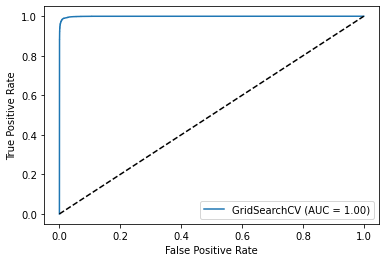

In [34]:
# roc auc curve
plot_roc_curve(grid3, X_train, y_train)
plt.plot([0,1], [0,1], 'k--');

In [12]:
words = grid3.best_estimator_.named_steps['countvectorizer'].get_feature_names()
word_coefs = grid3.best_estimator_.named_steps['logisticregression'].coef_[0]
word_coef_df = pd.DataFrame({'coefs': word_coefs, 'word': words})

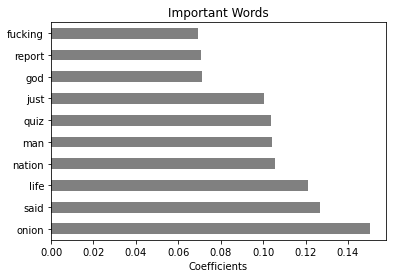

In [53]:
word_coef_df.nlargest(10, 'coefs').plot(kind = 'barh', legend=None, color='grey')
plt.yticks([i for i in range(10)], word_coef_df.nlargest(10, 'coefs')['word'])
plt.xlabel('Coefficients')
plt.title('Important Words')
plt.savefig('figures/logr_important_words.png', bbox_inches='tight');

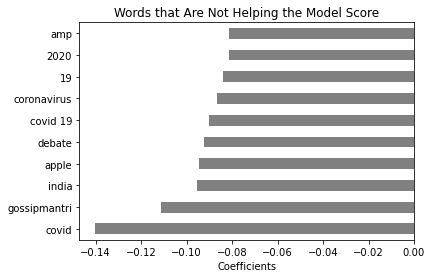

In [54]:
word_coef_df.nsmallest(10, 'coefs').plot(kind = 'barh', legend=None, color='grey')
plt.yticks([i for i in range(10)], word_coef_df.nsmallest(10, 'coefs')['word'])
plt.xlabel('Coefficients')
plt.title('Words that Are Not Helping the Model Score')
plt.savefig('figures/logr_not_important_words.png', bbox_inches='tight');